In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#read train image with CV
train_dir = '/data/tmpexec/ecg/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/tmpexec/ecg/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [7]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.linear = nn.Sequential(
            #nn.Linear(16*128*128, 4096),
            #nn.ReLU(inplace=True),
            nn.Linear(16*128*128, code_size),
            #nn.ReLU(inplace=True) #nn.Tanh()#[-1,1]
        )
        
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

            
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

    
#Generate image pairs for model
def onlineGenImgPairs(smlspl, bigspl):
    idx_sf = random.sample(range(0, len(bigspl)),len(smlspl))
    idx_sf.extend(list(smlspl))
    random.shuffle(idx_sf)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf
smlspl = np.where( np.array(trY) > 0 ) #samll sample
bigspl = np.where( np.array(trY) == 0 ) #big sample
#trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs(smlspl[0], bigspl[0]) #sample

#define model
hash_size=24
model = ASHNet(code_size=hash_size).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs(smlspl[0], bigspl[0]) #sample again
    losses = []
    num_batches = len(trY_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(hash_size) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

 546 / 546 : loss = 0.294733Eopch:     1 mean_loss = 0.971631
 546 / 546 : loss = 0.028961Eopch:     2 mean_loss = 0.675360
 546 / 546 : loss = 0.047495Eopch:     3 mean_loss = 0.559917
 546 / 546 : loss = 0.035413Eopch:     4 mean_loss = 0.512035
 546 / 546 : loss = 0.033044Eopch:     5 mean_loss = 0.458218
 546 / 546 : loss = 0.563144Eopch:     6 mean_loss = 0.434092
 546 / 546 : loss = 0.027063Eopch:     7 mean_loss = 0.399067
 546 / 546 : loss = 0.031128Eopch:     8 mean_loss = 0.376653
 546 / 546 : loss = 0.724947Eopch:     9 mean_loss = 0.368996
 546 / 546 : loss = 0.248426Eopch:    10 mean_loss = 0.352400
best_loss = 0.352400
 1999 / 2000 Completed buliding index in 1 seconds
Accuracy: 0.790800
[[12385   115  2123   223     0]
 [  605   150   185     4     0]
 [  438    26  3274    50     0]
 [  292     0   114     7     1]
 [    6     0     2     0     0]]
Specificity: 0.834231
Sensitivity of S: 0.158898
Sensitivity of V: 0.864308
Sensitivity of F: 0.016908
Sensitivity of Q: 0.

Org data dimension is 24.Embedded data dimension is 2


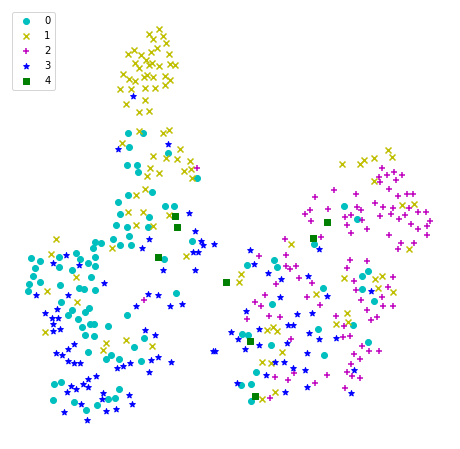

In [11]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()[0:100]
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()[0:100]
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()[0:100]
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()[0:100]
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

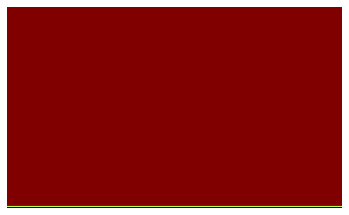

In [9]:
#feature map
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
 
# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

image_path = '/data/tmpexec/ecg/test/9929-2.png' #V:Ventricular ectopic beat
oriImg = cv2.imread(image_path)
height, width, _ = oriImg.shape
#plt.axis('off')
#plt.imshow(oriImg)
data = []
oriImg = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
data.append(oriImg)
data = torch.from_numpy(np.array(data)).type(torch.FloatTensor).cuda() 

activation = {}
best_net.sa.register_forward_hook(get_activation('sa'))#spatial attention
output = best_net(data.permute(0, 3, 1, 2))
feature = activation['sa'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(featuremap)

In [4]:
#PHA
def avhash(im): #Perceptual hash algorithm
    if not isinstance(im, Image.Image):
        im = Image.open(im)
    im = im.resize((16, 16), Image.ANTIALIAS).convert('L')
    avg = reduce(lambda x, y: x + y, im.getdata()) / 64.
    return reduce(lambda x, yz: x | (yz[1] << yz[0]),
                  enumerate(map(lambda i: 0 if i < avg else 1, im.getdata())),
                  0)
#read train image with CV
train_dir = '/data/tmpexec/ecg/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_GRAYSCALE).astype(np.float32), (128, 128))
            trI.append(img.flatten())
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/tmpexec/ecg/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_GRAYSCALE).astype(np.float32), (128, 128))
            teI.append(img.flatten())
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(128*128) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trI, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teI, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000
Completed buliding index in 3 seconds
Accuracy: 0.745600
[[11900   133  2069   739     5]
 [  737    24   172    11     0]
 [  633    31  2977   144     3]
 [  215     5   183    11     0]
 [    5     0     3     0     0]]
Specificity: 0.801563
Sensitivity of S: 0.025424
Sensitivity of V: 0.785903
Sensitivity of F: 0.026570
Sensitivity of Q: 0.000000


In [8]:
#Beats generation,
#we defined a single ECG beat image by centering the Q-wave peak signal while
#excluding the first and the last 20 ECG signals from the previous and afterward Q-wave peak signal
#https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
#https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
#http://www.tara.tcd.ie/bitstream/handle/2262/17623/automatic.pdf?sequence=1
def labeltotext(val):
    if val in ['N','L','R','e','j'] :
        return 0 #N
    elif val in ['A','a','J','S']:
        return 1 #S
    elif val in ['V','E']:
        return 2 #V
    elif val == 'F':
        return 3 #F
    elif val in ['/','f','Q']:
        return 4 #Q
    else: 
        pass
    
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 180 #left sample length around of peak value of QRS
#get trainset
trData = [] #[QRS value, label]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]:#22 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    trData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass
    
NOR = 14846 #normal samples    
trData = pd.DataFrame(np.array(trData))
NData =  trData[trData[1]==0].sample(n=NOR, random_state=1)
UNData = trData[trData[1]!=0]
trData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS1 = pd.DataFrame(trData[0].values.tolist())
y_DS1 = trData[1]
print('The shape of DS1 is: (%d,%d)'%(X_DS1.shape[0],X_DS1.shape[1]))
print(trData[1].value_counts())

#get testset
teData = [] #[QRS value, label]
for bt in [100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:#22 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    teData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass

NOR = 14548 #normal samples    
teData = pd.DataFrame(np.array(teData))
NData =  teData[teData[1]==0].sample(n=NOR, random_state=1)
UNData = teData[teData[1]!=0]
teData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS2 = pd.DataFrame(teData[0].values.tolist())
y_DS2 = teData[1]
print('The shape of DS2 is: (%d,%d)'%(X_DS2.shape[0],X_DS2.shape[1]))
print(teData[1].value_counts())

#model: faiss+index
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(right_len+left_len) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(X_DS2, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(X_DS1, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(y_DS2)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_DS1.tolist(), y_pred))
#confusion matrix
labels = list(set(y_DS1))
cm = confusion_matrix(y_DS1.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

The shape of DS1 is: (20000,360)
0    14846
2     3788
1      944
3      414
4        8
Name: 1, dtype: int64
The shape of DS2 is: (20000,360)
0    14548
2     3220
1     1837
3      388
4        7
Name: 1, dtype: int64
Completed buliding index in 1 seconds
Accuracy: 0.807300
[[12802   419  1340   285     0]
 [  638   148   151     7     0]
 [  518    79  3158    33     0]
 [  277     1    98    38     0]
 [    6     0     2     0     0]]
Specificity: 0.862320
Sensitivity of S: 0.156780
Sensitivity of V: 0.833685
Sensitivity of F: 0.091787
Sensitivity of Q: 0.000000


In [9]:
#import ecg_plot#pip install ecg_plot, https://pypi.org/project/ecg-plot/
#from scipy.misc import electrocardiogram 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html
fs = 360
for idx,row in X_DS2.iterrows():
    label = np.array(y_DS2)[idx]
    svpath = os.path.join('/data/tmpexec/ecg/train',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS2.shape[0]))
    sys.stdout.flush()
for idx,row in X_DS1.iterrows():
    label = np.array(y_DS1)[idx]
    svpath = os.path.join('/data/tmpexec/ecg/test',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS1.shape[0]))
    sys.stdout.flush()

19999 / 20000 